# 🔄 Online learning in non-stationary environments 🔄

We reproduce the empirical results of [1].

## References

[1] [Anava, O., Hazan, E., Mannor, S. and Shamir, O., 2013, June. Online learning for time series prediction. In Conference on learning theory (pp. 172-184)](https://arxiv.org/pdf/1302.6927.pdf)



In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from typing import Any, NamedTuple

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as onp
import optax
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from wax.modules import ARMA, SNARIMAX, GymFeedback, OnlineOptimizer, UpdateParams, VMap
from wax.modules.lag import tree_lag
from wax.modules.vmap import add_batch
from wax.optim import newton
from wax.unroll import unroll_transform_with_state

In [3]:
T = 10000
N_BATCH = 20
N_STEP_SIZE = 30
N_STEP_SIZE_NEWTON = 10
N_EPS = 5

## Agent

In [6]:
OPTIMIZERS = [optax.sgd, optax.adagrad, optax.rmsprop, optax.adam]

In [7]:
from optax._src.base import OptState


def build_agent(time_series_model=None, opt=None):
    if time_series_model is None:
        time_series_model = lambda y, X: SNARIMAX(10)(y, X)

    if opt is None:
        opt = optax.sgd(1.0e-3)

    class AgentInfo(NamedTuple):
        optim: Any
        forecast: Any

    class ModelWithLossInfo(NamedTuple):
        pred: Any
        loss: Any

    def agent(obs):
        if isinstance(obs, tuple):
            y, X = obs
        else:
            y = obs
            X = None

        def evaluate(y_pred, y):
            return jnp.linalg.norm(y_pred - y) ** 2, {}

        def model_with_loss(y, X=None):
            # predict with lagged data
            y_pred, pred_info = time_series_model(*tree_lag(1)(y, X))

            # evaluate loss with actual data
            loss, loss_info = evaluate(y_pred, y)

            return loss, ModelWithLossInfo(pred_info, loss_info)

        def project_params(params: Any, opt_state: OptState = None):
            del opt_state
            return jax.tree_map(lambda w: jnp.clip(w, -1, 1), params)

        def split_params(params):
            def filter_params(m, n, p):
                # print(m, n, p)
                return m.endswith("snarimax/~/linear") and n == "w"

            return hk.data_structures.partition(filter_params, params)

        def learn_and_forecast(y, X=None):
            # use lagged data for the optimizer
            optim_res = OnlineOptimizer(
                model_with_loss,
                opt,
                project_params=project_params,
                split_params=split_params,
            )(*tree_lag(1)(y, X))

            # use updated params to forecast with actual data
            predict_params = optim_res.updated_params

            y_pred, forecast_info = UpdateParams(time_series_model)(
                predict_params, y, X
            )
            return y_pred, AgentInfo(optim_res, forecast_info)

        return learn_and_forecast(y, X)

    return agent

## Non-stationary environments


We will now wrapup the study of an environment + agent in few analysis functions.

We will then use them to perform the same analysis in the non-stationary setting proposed in [1], namely:

  * setting 1 : sanity check (stationary ARMA environment).
  * setting 2 : slowly varying parameters.
  * setting 3 : brutal variation of parameters.
  * setting 4 : non-stationary (random walk) noise.

## Analysis functions

For each solver, we will select the best hyper parameters (step size $\eta$, $\epsilon$)
by measuring the average loss between the 5000 and 10000 steps.

### First order solvers





In [8]:
def scan_hparams_first_order():

    STEP_SIZE_idx = pd.Index(onp.logspace(-4, 1, N_STEP_SIZE), name="step_size")
    STEP_SIZE = jax.device_put(STEP_SIZE_idx.values)

    rng = jax.random.PRNGKey(42)
    eps = sample_noise(rng)

    res = {}
    for optimizer in tqdm(OPTIMIZERS):

        def gym_loop_scan_hparams(eps):
            def scan_params(step_size):
                return GymFeedback(build_agent(opt=optimizer(step_size)), env)(eps)

            res = VMap(scan_params)(STEP_SIZE)
            return res

        sim = unroll_transform_with_state(add_batch(gym_loop_scan_hparams))

        params, state = sim.init(rng, eps)
        _res, state = sim.apply(params, state, rng, eps)
        res[optimizer.__name__] = _res

    ax = None
    BEST_STEP_SIZE = {}
    BEST_GYM = {}

    for name, (gym, info) in res.items():

        loss = (
            pd.DataFrame(-gym.reward, columns=STEP_SIZE).iloc[LEARN_TIME_SLICE].mean()
        )

        BEST_STEP_SIZE[name] = loss.idxmin()

        best_idx = jnp.argmax(gym.reward[LEARN_TIME_SLICE].mean(axis=0))
        BEST_GYM[name] = jax.tree_map(lambda x: x[:, best_idx], gym)

        ax = loss.plot(
            logx=True, logy=False, ax=ax, label=name, ylim=(MIN_ERR, MAX_ERR)
        )
    plt.legend()

    return BEST_STEP_SIZE, BEST_GYM

We will "cross-validate" the result by running the agent on new samples.

In [9]:
CROSS_VAL_RNG = jax.random.PRNGKey(44)

In [10]:
COLORS = sns.color_palette("hls")

In [11]:
def cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM):
    plt.figure()
    eps = sample_noise(CROSS_VAL_RNG)
    CROSS_VAL_GYM = {}
    ax = None

    # def measure(reward):
    #     return pd.Series(-reward).rolling(T/2, min_periods=T/2).mean()

    def measure(reward):
        return pd.Series(-reward).expanding().mean()

    for i, (name, gym) in enumerate(BEST_GYM.items()):
        ax = measure(gym.reward).plot(
            ax=ax,
            color=COLORS[i],
            label=(f"(TRAIN) -  {name}    " f"-    $\eta$={BEST_STEP_SIZE[name]:.2e}"),
            style="--",
        )
    for i, optimizer in enumerate(tqdm(OPTIMIZERS)):

        name = optimizer.__name__

        def gym_loop(eps):
            return GymFeedback(build_agent(opt=optimizer(BEST_STEP_SIZE[name])), env)(
                eps
            )

        sim = unroll_transform_with_state(add_batch(gym_loop))

        rng = jax.random.PRNGKey(42)
        params, state = sim.init(rng, eps)
        (gym, info), state = sim.apply(params, state, rng, eps)
        CROSS_VAL_GYM[name] = gym

        ax = measure(gym.reward).plot(
            ax=ax,
            color=COLORS[i],
            ylim=(MIN_ERR, MAX_ERR),
            label=(
                f"(VALIDATE) -  {name}    " f"-    $\eta$={BEST_STEP_SIZE[name]:.2e}"
            ),
        )
    plt.legend()

    return CROSS_VAL_GYM

### Newton solver





In [12]:
def scan_hparams_newton():
    STEP_SIZE = pd.Index(onp.logspace(-2, 3, N_STEP_SIZE_NEWTON), name="step_size")
    EPS = pd.Index(onp.logspace(-4, 3, N_EPS), name="eps")

    HPARAMS_idx = pd.MultiIndex.from_product([STEP_SIZE, EPS])
    HPARAMS = jnp.stack(list(map(onp.array, HPARAMS_idx)))

    @add_batch
    def gym_loop_scan_hparams(eps):
        def scan_params(hparams):
            step_size, newton_eps = hparams
            agent = build_agent(opt=newton(step_size, eps=newton_eps))
            return GymFeedback(agent, env)(eps)

        return VMap(scan_params)(HPARAMS)

    sim = unroll_transform_with_state(gym_loop_scan_hparams)

    rng = jax.random.PRNGKey(42)
    eps = sample_noise(rng)

    params, state = sim.init(rng, eps)
    res_newton, state = sim.apply(params, state, rng, eps)

    gym_newton, info_newton = res_newton

    loss_newton = (
        pd.DataFrame(-gym_newton.reward, columns=HPARAMS_idx)
        .iloc[LEARN_TIME_SLICE]
        .mean()
        .unstack()
    )

    sns.heatmap(loss_newton[loss_newton < 0.4], annot=True, cmap="YlGnBu")

    STEP_SIZE, NEWTON_EPS = loss_newton.stack().idxmin()

    x = -gym_newton.reward[LEARN_TIME_SLICE].mean(axis=0)
    x = jax.ops.index_update(x, jnp.isnan(x), jnp.inf)
    I_BEST_PARAM = jnp.argmin(x)

    BEST_NEWTON_GYM = jax.tree_map(lambda x: x[:, I_BEST_PARAM], gym_newton)
    print("Best newton parameters: ", STEP_SIZE, NEWTON_EPS)
    return (STEP_SIZE, NEWTON_EPS), BEST_NEWTON_GYM

In [13]:


def cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM):
    (STEP_SIZE, NEWTON_EPS) = BEST_HPARAMS
    plt.figure()

    # def measure(reward):
    #     return pd.Series(-reward).rolling(T/2, min_periods=T/2).mean()

    def measure(reward):
        return pd.Series(-reward).expanding().mean()

    @add_batch
    def gym_loop(eps):
        agent = build_agent(opt=newton(STEP_SIZE, eps=NEWTON_EPS))
        return GymFeedback(agent, env)(eps)

    sim = unroll_transform_with_state(gym_loop)

    rng = jax.random.PRNGKey(44)
    eps = sample_noise(rng)
    params, state = sim.init(rng, eps)
    (gym, info), state = sim.apply(params, state, rng, eps)

    ax = None
    i = 4
    ax = measure(BEST_NEWTON_GYM.reward).plot(
        ax=ax,
        color=COLORS[i],
        label=f"(TRAIN) -  Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}",
        ylim=(MIN_ERR, MAX_ERR),
        style="--",
    )

    ax = measure(gym.reward).plot(
        ax=ax,
        color=COLORS[i],
        ylim=(MIN_ERR, MAX_ERR),
        label=f"(VALIDATE) - Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}",
    )

    plt.legend()

    return gym

### Plot everithing





In [14]:
def plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM):
    MESURES = []

    def measure(reward):
        return pd.Series(-reward).rolling(int(T / 2), min_periods=int(T / 2)).mean()

    MESURES.append(("Rolling mean of loss (5000) time-steps", measure))

    def measure(reward):
        return pd.Series(-reward).expanding().mean()

    MESURES.append(("Expanding means", measure))

    for MEASURE_NAME, MEASUR_FUNC in MESURES:

        plt.figure()

        for i, (name, gym) in enumerate(BEST_GYM.items()):
            MEASUR_FUNC(gym.reward).plot(
                label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}",
                ylim=(MIN_ERR, MAX_ERR),
                color=COLORS[i],
            )

        i = 4
        (STEP_SIZE, NEWTON_EPS) = BEST_HPARAMS
        gym = BEST_NEWTON_GYM
        ax = MEASUR_FUNC(gym.reward).plot(
            label=f"Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}",
            ylim=(MIN_ERR, MAX_ERR),
            color=COLORS[i],
        )
        ax.legend(bbox_to_anchor=(1.0, 1.0))
        plt.title(MEASURE_NAME)

## Setting 1

### Environment

let's wrapup the results for the "setting 1" in [1]

In [15]:
from wax.modules import Counter


def build_env():
    def env(action, obs):
        y_pred, eps = action, obs

        ar_coefs = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
        ma_coefs = jnp.array([0.3, -0.2])

        y = ARMA(ar_coefs, ma_coefs)(eps)

        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env


def sample_noise(rng):
    eps = jax.random.normal(rng, (T, 20)) * 0.3
    return eps


MIN_ERR = 0.09
MAX_ERR = 0.15
LEARN_TIME_SLICE = slice(int(T / 2), T)
env = build_env()

  0%|          | 0/4 [00:00<?, ?it/s]

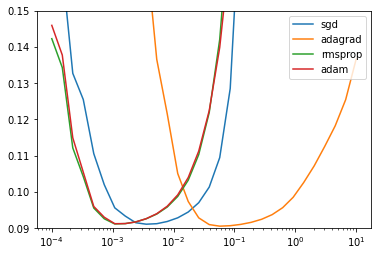

In [16]:
BEST_STEP_SIZE, BEST_GYM = scan_hparams_first_order()

  0%|          | 0/4 [00:00<?, ?it/s]

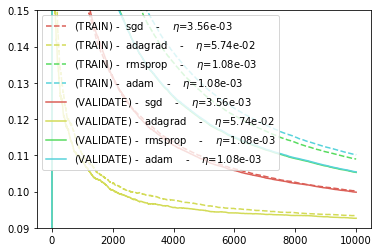

In [17]:
CROSS_VAL_GYM = cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM)

Best newton parameters:  0.464158883361278 0.31622776601683794


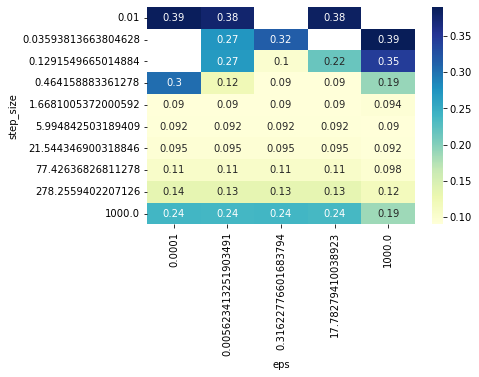

In [18]:
BEST_HPARAMS, BEST_NEWTON_GYM = scan_hparams_newton()

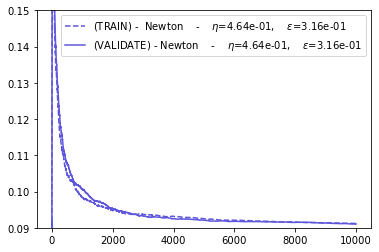

In [19]:
CROSS_VAL_GYM = cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM)

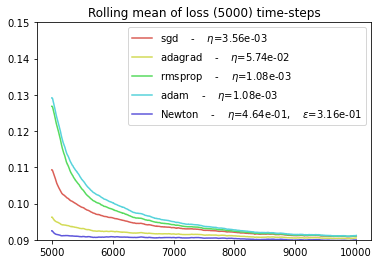

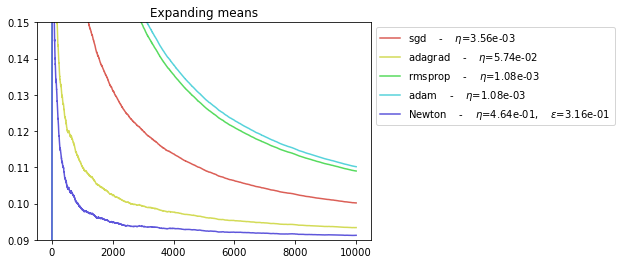

In [20]:
plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM)

### Conclusions

- The NEWTON and ADAGRAD optimizers are the faster to converge.
- The SGD and ADAM optimizers have the worst performance.

### Fixed setting

In [21]:
@add_batch
def gym_loop_newton(eps):
    return GymFeedback(build_agent(opt=newton(0.1, eps=0.3)), env)(eps)


def run_fixed_setting():
    rng = jax.random.PRNGKey(42)
    eps = sample_noise(rng)
    sim = unroll_transform_with_state(gym_loop_newton)
    params, state = sim.init(rng, eps)
    (gym, info), state = sim.apply(params, state, rng, eps)

    pd.Series(-gym.reward).expanding().mean().plot()  # ylim=(MIN_ERR, MAX_ERR))

CPU times: user 1.69 s, sys: 19.4 ms, total: 1.71 s
Wall time: 1.7 s


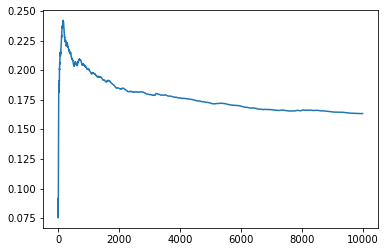

In [22]:
%%time
run_fixed_setting()

## Setting 2

### Environment

let's build an environment corresponding to "setting 2" in [1]

In [23]:
from wax.modules import Counter


def build_env():
    def env(action, obs):
        y_pred, eps = action, obs
        t = Counter()()
        ar_coefs_1 = jnp.array([-0.4, -0.5, 0.4, 0.4, 0.1])
        ar_coefs_2 = jnp.array([0.6, -0.4, 0.4, -0.5, 0.5])
        ar_coefs = ar_coefs_1 * t / T + ar_coefs_2 * (1 - t / T)

        ma_coefs = jnp.array([0.32, -0.2])

        y = ARMA(ar_coefs, ma_coefs)(eps)
        # prediction used on a fresh y observation.
        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env


def sample_noise(rng):
    eps = jax.random.uniform(rng, (T, 20), minval=-0.5, maxval=0.5)
    return eps


MIN_ERR = 0.0833
MAX_ERR = 0.15
LEARN_TIME_SLICE = slice(int(T / 2), T)
env = build_env()

  0%|          | 0/4 [00:00<?, ?it/s]

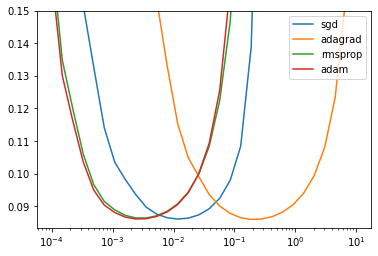

In [24]:
BEST_STEP_SIZE, BEST_GYM = scan_hparams_first_order()

  0%|          | 0/4 [00:00<?, ?it/s]

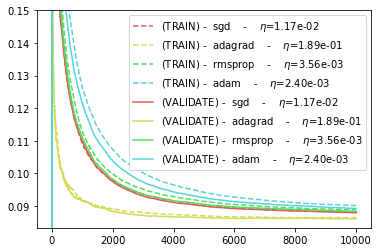

In [25]:
CROSS_VAL_GYM = cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM)

Best newton parameters:  1.6681005372000592 0.31622776601683794


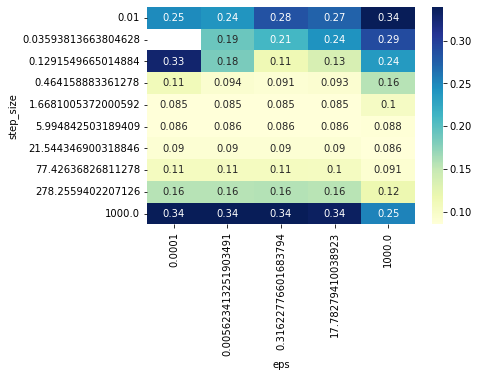

In [26]:
BEST_HPARAMS, BEST_NEWTON_GYM = scan_hparams_newton()

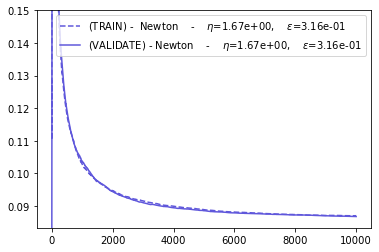

In [27]:
CROSS_VAL_GYM = cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM)

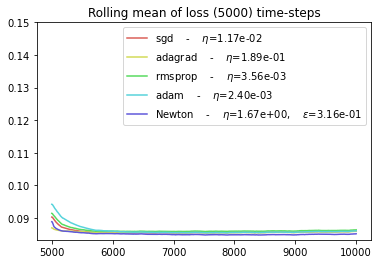

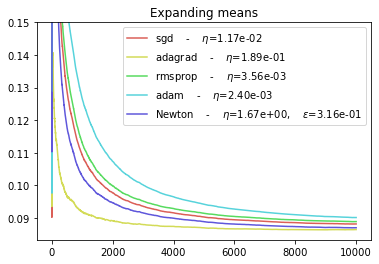

In [28]:
plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM)

### Conclusions

- The NEWTON and ADAGRAD optimizers are more efficient to adapt to slowly changing environments.
- The SGD and ADAM optimizers seem to have the worst performance.

### Fixed setting

CPU times: user 1.77 s, sys: 22.5 ms, total: 1.79 s
Wall time: 1.76 s


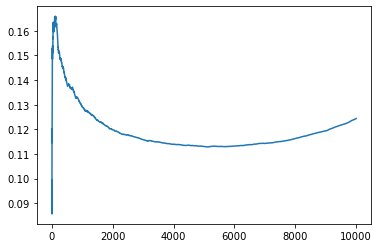

In [29]:
%%time
run_fixed_setting()

## Setting 3

### Environment

Let us build an environment corresponding to the "setting 3" of [1].
We modify it slightly by adding 10000 steps. We intentionally use
use the 5000 to 10000 steps to optimize the hyper parameters.
This allows us to evaluate how the models "over-optimize".

In [30]:
from wax.modules import Counter


def build_env():
    def env(action, obs):
        y_pred, eps = action, obs
        t = Counter()()
        ar_coefs_1 = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
        ar_coefs_2 = jnp.array([-0.4, -0.5, 0.4, 0.4, 0.1])

        ar_coefs = jnp.where(t < int(Tlong / 2), ar_coefs_1, ar_coefs_2)
        ma_coefs_1 = jnp.array([0.3, -0.2])
        ma_coefs_2 = jnp.array([-0.3, 0.2])
        ma_coefs = jnp.where(t < int(Tlong / 2), ma_coefs_1, ma_coefs_2)

        y = ARMA(ar_coefs, ma_coefs)(eps)

        # prediction used on a fresh y observation.
        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env


def sample_noise(rng):
    eps = jax.random.uniform(rng, (Tlong, N_BATCH), minval=-0.5, maxval=0.5)
    return eps


Tlong = 2 * T
MIN_ERR = 0.0833
MAX_ERR = 0.12
LEARN_TIME_SLICE = slice(int(T / 2), T)
env = build_env()

  0%|          | 0/4 [00:00<?, ?it/s]

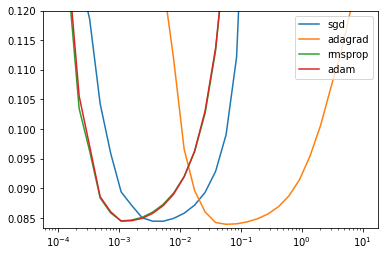

In [31]:
BEST_STEP_SIZE, BEST_GYM = scan_hparams_first_order()

  0%|          | 0/4 [00:00<?, ?it/s]

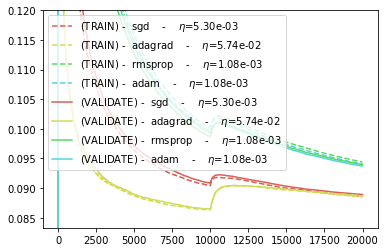

In [32]:
CROSS_VAL_GYM = cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM)

Best newton parameters:  0.464158883361278 17.78279410038923


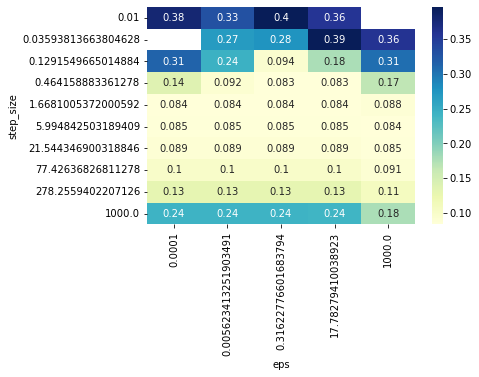

In [33]:
BEST_HPARAMS, BEST_NEWTON_GYM = scan_hparams_newton()

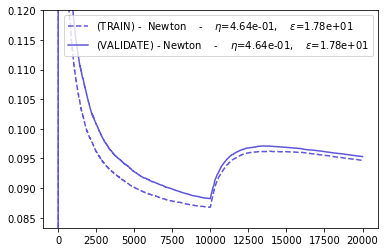

In [34]:
CROSS_VAL_GYM = cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM)

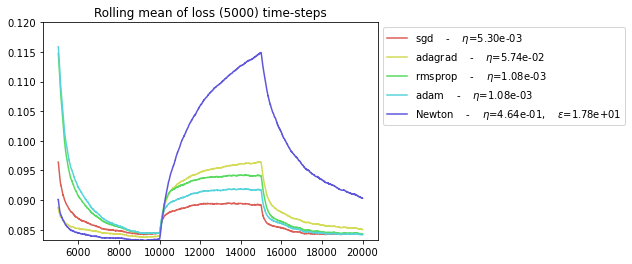

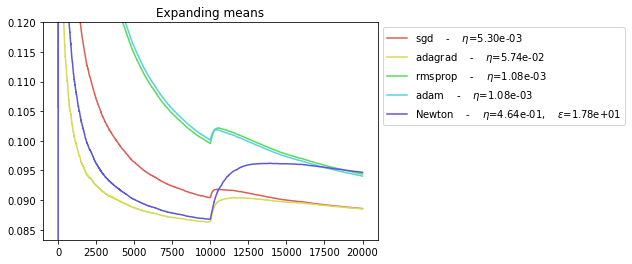

In [35]:
plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM)

### Choosing hyper parameters on the whole period

It seems that Newton solver is more prone to overfitting (recall that we chose its hyper parameters to optimize the average loss between steps 5000 and 1000, thus only in the first regime).


However, as stated in [1], Newton algorithm can have better performances if we choose its hyper parameters in order to obtain the best performances for both regimes.

Let us check this:

In [36]:
LEARN_TIME_SLICE = slice(int(Tlong / 2), None)
env = build_env()

  0%|          | 0/4 [00:00<?, ?it/s]

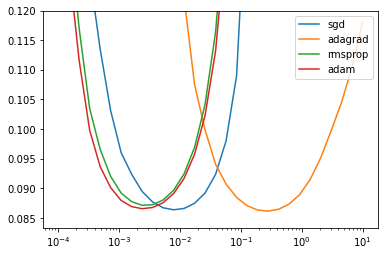

In [37]:
BEST_STEP_SIZE, BEST_GYM = scan_hparams_first_order()

  0%|          | 0/4 [00:00<?, ?it/s]

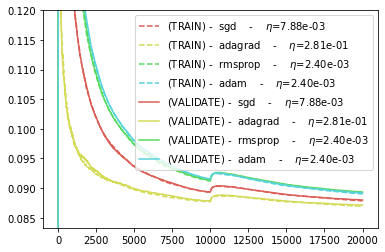

In [38]:
CROSS_VAL_GYM = cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM)

Best newton parameters:  5.994842503189409 17.78279410038923


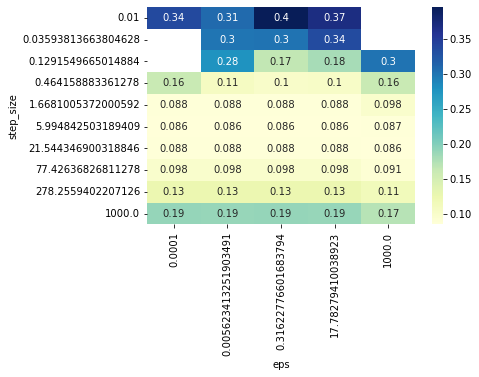

In [39]:
BEST_HPARAMS, BEST_NEWTON_GYM = scan_hparams_newton()

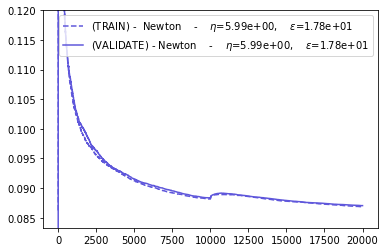

In [40]:
CROSS_VAL_GYM = cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM)

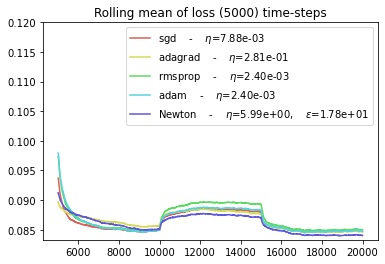

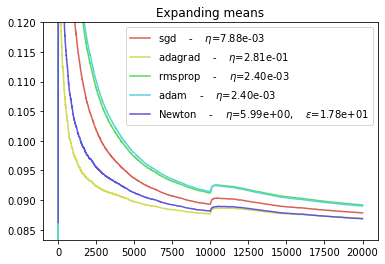

In [41]:
plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM)

### Conclusion

- The ADAGRAD optimizers seems to be best suited for abrupt regime switching.
- The SGD and NEWTON optimizers seem to behave similarly if their parameters are correctly chosen.
- The ADAM optimizer seems to have the worst performance.

### Fixed setting

CPU times: user 2.2 s, sys: 32.6 ms, total: 2.23 s
Wall time: 2.23 s


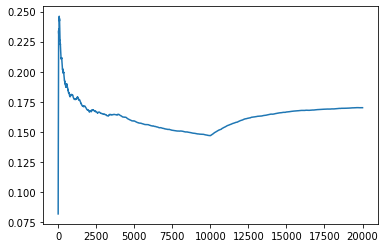

In [42]:
%%time
run_fixed_setting()

## Setting 4

### Environment

let's build an environment corresponding to "setting 4" in [1]

In [43]:
from wax.modules import Counter


def build_env():
    def env(action, obs):
        y_pred, eps = action, obs
        t = Counter()()
        ar_coefs = jnp.array([0.11, -0.5])

        ma_coefs = jnp.array([0.41, -0.39, -0.685, 0.1])

        # rng = hk.next_rng_key()

        prev_eps = hk.get_state("prev_eps", (1,), init=lambda *_: jnp.zeros_like(eps))
        eps = prev_eps + eps  # jax.random.normal(rng, (1, N_BATCH))

        hk.set_state("prev_eps", eps)

        y = ARMA(ar_coefs, ma_coefs)(eps)
        # prediction used on a fresh y observation.
        rw = -((y - y_pred) ** 2)

        env_info = {"y": y, "y_pred": y_pred}
        obs = y
        return rw, obs, env_info

    return env


def sample_noise(rng):
    eps = jax.random.normal(rng, (T, N_BATCH)) * 0.3
    return eps


MIN_ERR = 0.09
MAX_ERR = 0.3
LEARN_TIME_SLICE = slice(int(T / 2), T)
env = build_env()

  0%|          | 0/4 [00:00<?, ?it/s]

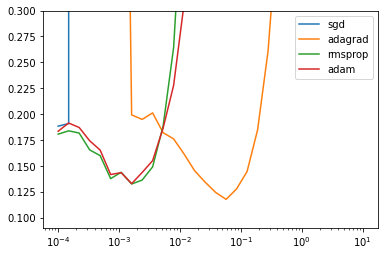

In [44]:
BEST_STEP_SIZE, BEST_GYM = scan_hparams_first_order()

In [45]:
BEST_STEP_SIZE

{'sgd': 9.999999747378752e-05,
 'adagrad': 0.05736152455210686,
 'rmsprop': 0.0016102619701996446,
 'adam': 0.0016102619701996446}

  0%|          | 0/4 [00:00<?, ?it/s]

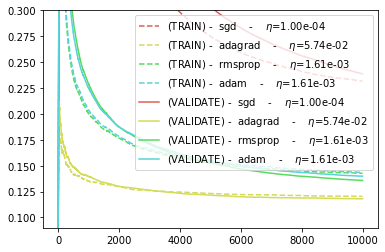

In [46]:
CROSS_VAL_GYM = cross_validate_first_order(BEST_STEP_SIZE, BEST_GYM)

Best newton parameters:  0.464158883361278 0.31622776601683794


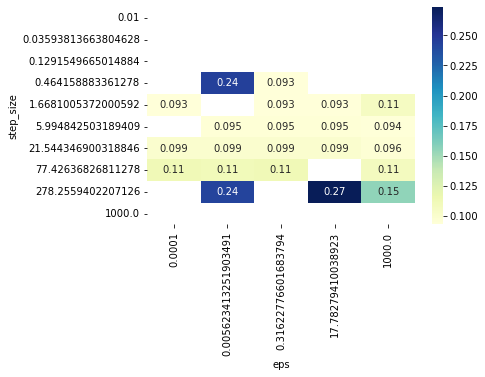

In [47]:
BEST_HPARAMS, BEST_NEWTON_GYM = scan_hparams_newton()

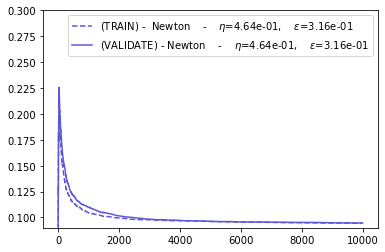

In [48]:
CROSS_VAL_GYM = cross_validate_newton(BEST_HPARAMS, BEST_NEWTON_GYM)

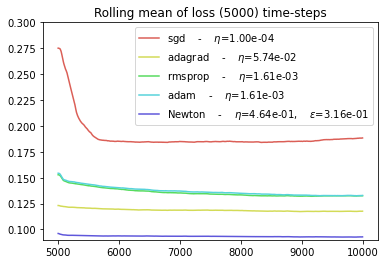

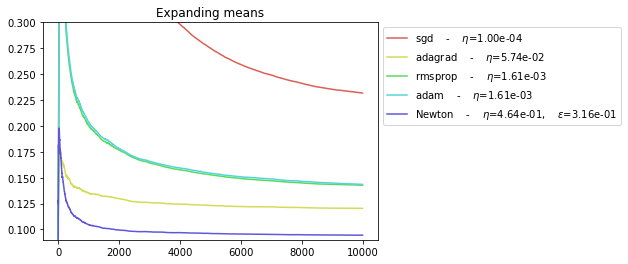

In [49]:
plot_everything(BEST_STEP_SIZE, BEST_GYM, BEST_HPARAMS, BEST_NEWTON_GYM)

As noted in [1], the newton algorithm seems to be the only one to achieve an average error rate that converges to the variance of the noise (0.09).


### Conclusion

In this environment with noise auto-correlations:
- The NEWTON optimizer achieve to realize the minimum theoretical average loss
- The other optimizers struggle to converge to the minimum theoretical loss and thus seems to suffer a linear regret.
- The SGD optimizer is the worst in this setting.

### Fixed setting

CPU times: user 1.84 s, sys: 16.5 ms, total: 1.86 s
Wall time: 1.85 s


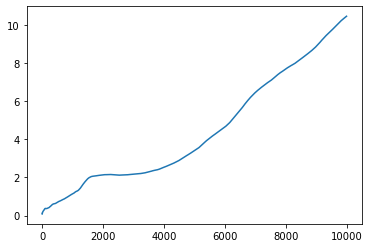

In [50]:
%%time
run_fixed_setting()